In [1]:
import os
images_dir = 'images'

import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
import datetime
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

import seaborn as sns

In [2]:
df = pd.read_csv('UserBehavior.csv')

查看数据并展示

In [3]:
df.head()

,user id,item id,item category id,behavior type,time
0,1,2268318,2520377,pv,1511544070
1,1,2333346,2520771,pv,1511561733
2,1,2576651,149192,pv,1511572885
3,1,3830808,4181361,pv,1511593493
4,1,4365585,2520377,pv,1511596146


In [4]:
# 查看数据基本信息
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100150807 entries, 0 to 100150806
Data columns (total 5 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   user id           int64 
 1   item id           int64 
 2   item category id  int64 
 3   behavior type     object
 4   time              int64 
dtypes: int64(4), object(1)
memory usage: 3.7+ GB


In [5]:
# 查看缺失值
df.isnull().sum()

user id             0
item id             0
item category id    0
behavior type       0
time                0
dtype: int64

In [6]:
# 查看每列值的类型数量
df.nunique()

user id              987994
item id             4162024
item category id       9439
behavior type             4
time                 815859
dtype: int64

数据清理

In [7]:
# 删除重复值
df = df.drop_duplicates(df)

In [8]:
# 转化日期格式（精确到秒）
df['time'] = pd.to_datetime(df['time'], unit='s') + datetime.timedelta(hours=8)

In [9]:
# 删除异常日期
startTime = datetime.datetime.strptime("2017-11-25 00:00:00","%Y-%m-%d %H:%M:%S")
endTime = datetime.datetime.strptime("2017-12-03 23:59:59","%Y-%m-%d %H:%M:%S")

df = df[(df['time'] <= endTime) & (df['time'] >= startTime)].copy()
df = df.reset_index(drop=True)

In [10]:
# 按照周和小时拆分
df['weekday'] = df.time.dt.weekday
df['hour'] = df.time.dt.hour

In [11]:
df.head()

,user id,item id,item category id,behavior type,time,weekday,hour
0,1,2268318,2520377,pv,2017-11-25 01:21:10,5,1
1,1,2333346,2520771,pv,2017-11-25 06:15:33,5,6
2,1,2576651,149192,pv,2017-11-25 09:21:25,5,9
3,1,3830808,4181361,pv,2017-11-25 15:04:53,5,15
4,1,4365585,2520377,pv,2017-11-25 15:49:06,5,15


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100095182 entries, 0 to 100095181
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   user id           int64         
 1   item id           int64         
 2   item category id  int64         
 3   behavior type     object        
 4   time              datetime64[ns]
 5   weekday           int32         
 6   hour              int32         
dtypes: datetime64[ns](1), int32(2), int64(3), object(1)
memory usage: 4.5+ GB


时间维度分析

In [13]:
weekday_labels = {
    0: "周一", 1: "周二", 2: "周三",
    3: "周四", 4: "周五", 5: "周六", 6: "周日"
}

In [14]:
weekday_df = df.groupby(['weekday', 'behavior type'])['behavior type'].count().unstack()

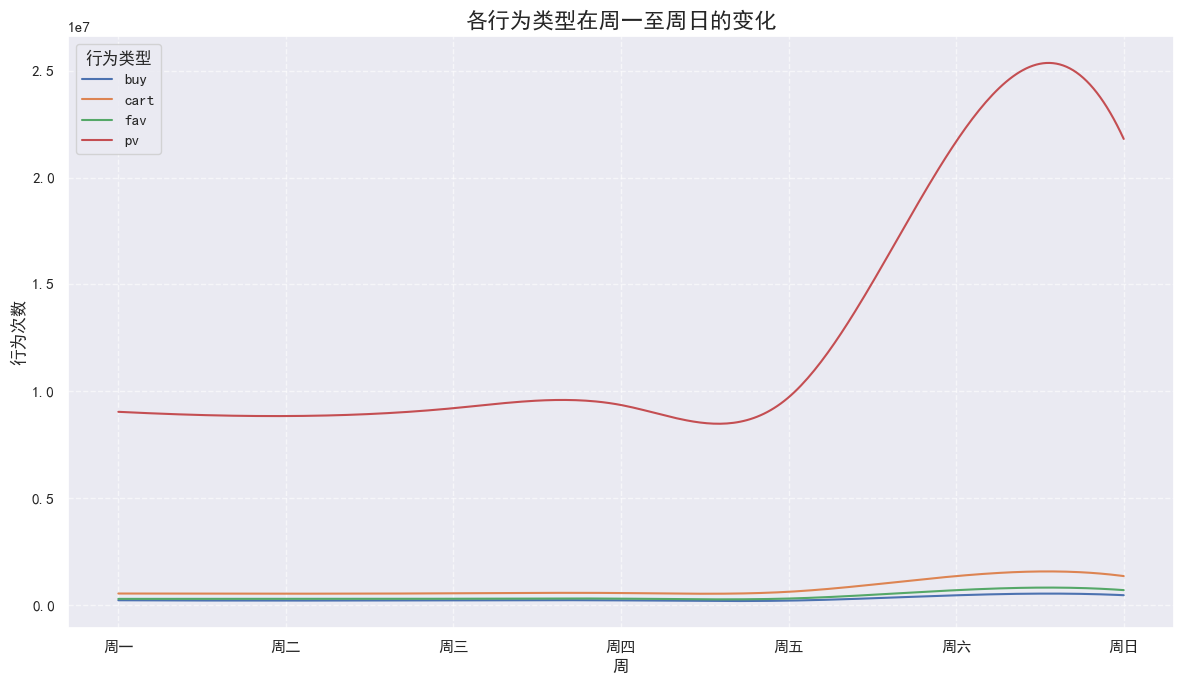

In [15]:
weekday_labels = ['周一','周二','周三','周四','周五','周六','周日']
x_original = weekday_df.index.values + 1
x_smooth = np.linspace(1, 7, 300)

sns.set(font='SimHei', rc={'axes.unicode_minus': False})
plt.figure(figsize=(12, 7))
ax = plt.gca()

for behavior in weekday_df.columns:
    y_original = weekday_df[behavior].values
    cs = CubicSpline(x_original, y_original)
    y_smooth = cs(x_smooth)
    ax.plot(x_smooth, y_smooth, label=behavior)

ax.set_title("各行为类型在周一至周日的变化", fontsize=16)
ax.set_xlabel("周", fontsize=12)
ax.set_ylabel("行为次数", fontsize=12)

ax.set_xticks(x_original)
ax.set_xticklabels(weekday_labels)

ax.legend(title='行为类型')
ax.grid(True, linestyle='--', alpha=0.6)
sns.set_style("darkgrid")

plt.tight_layout()

save_path_smooth = os.path.join(images_dir, 'weekday_behavior_seaborn_smooth_plot.png')
plt.savefig(save_path_smooth, dpi=300)
plt.show()
plt.close()

In [16]:
hour_df = df.groupby(['hour', 'behavior type'])['behavior type'].count().unstack()

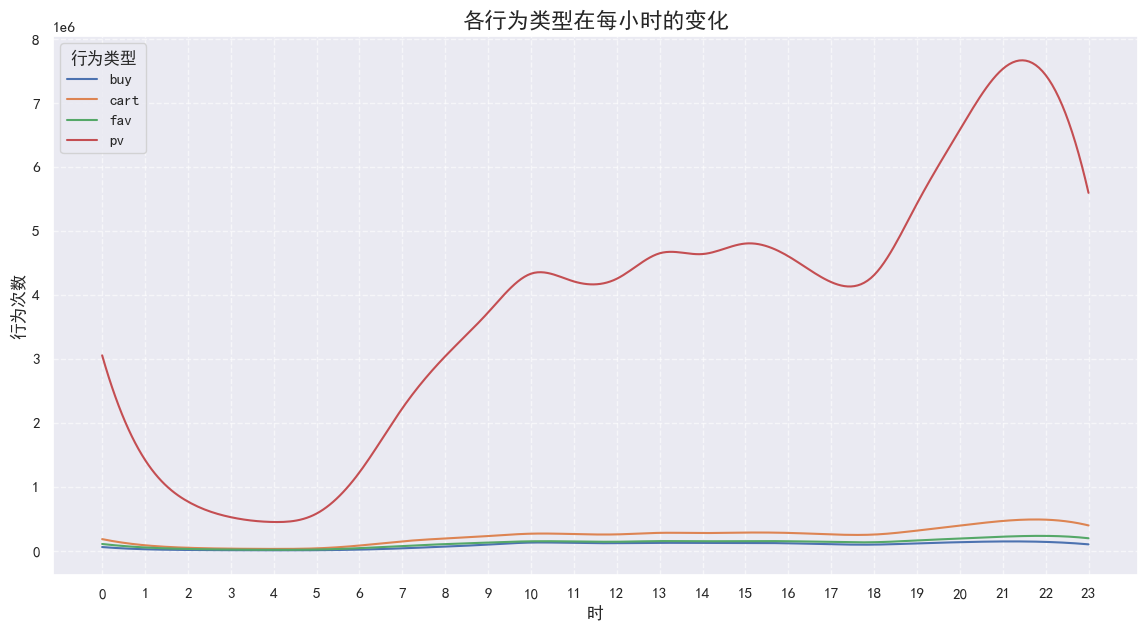

In [18]:
sns.set(font='SimHei', rc={'axes.unicode_minus': False})
plt.figure(figsize=(14, 7))
ax = plt.gca()
x_original = hour_df.index.values
x_smooth = np.linspace(x_original.min(), x_original.max(), 300)
for behavior in hour_df.columns:
    y_original = hour_df[behavior].values
    cs = CubicSpline(x_original, y_original)
    y_smooth = cs(x_smooth)
    ax.plot(x_smooth, y_smooth, label=behavior)
ax.set_title("各行为类型在每小时的变化", fontsize=16)
ax.set_xlabel("时", fontsize=12)
ax.set_xticks(x_original)
ax.set_xticklabels([f"{int(h)}" for h in x_original])
ax.set_ylabel("行为次数", fontsize=12)
ax.legend(title='行为类型')
ax.grid(True, linestyle='--', alpha=0.6)
sns.set_style("darkgrid")
save_path = os.path.join(images_dir, 'hourly_behavior_smooth_plot.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

用户价值RFM分析

In [19]:
df_buy = df[df['behavior type'] == 'buy'].copy()

# 每个用户购买的次数
buy_counts = df_buy.groupby('user id').size()

# 购买次数的分布（每个购买频次下有多少用户）
buy_distribution = buy_counts.value_counts().sort_index()

# 用户占比
buy_distribution_percent = buy_distribution / buy_distribution.sum()

buy_distribution_percent = buy_distribution_percent[buy_distribution_percent.index <= 30]

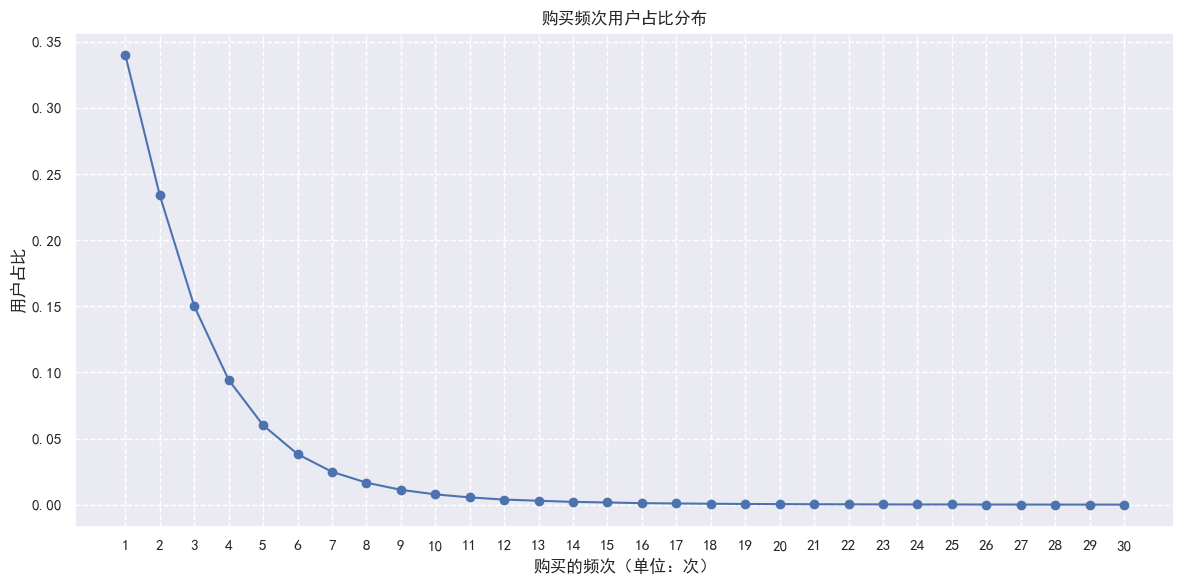

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(buy_distribution_percent.index, buy_distribution_percent.values, marker='o')
plt.xticks(range(1, 31))  # 横坐标显示 1~30
plt.xlabel("购买的频次（单位：次）")
plt.ylabel("用户占比")
plt.title("购买频次用户占比分布")

plt.grid(True, linestyle='--')
plt.tight_layout()

file_path = os.path.join(images_dir, '购买频次用户占比分布.png')
plt.savefig(file_path)

plt.show()

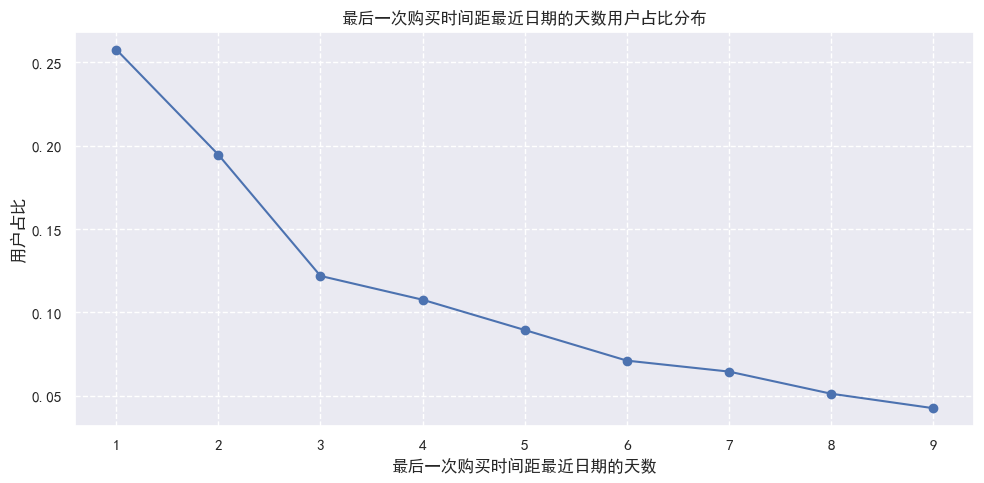

In [22]:
now = pd.to_datetime("2017-12-04")

last_buy_time = df_buy.groupby('user id')['time'].max()
days_since_last_buy = (now - last_buy_time).dt.days
days_since_last_buy += 1

day_distribution = days_since_last_buy.value_counts().sort_index()
day_distribution_percent = day_distribution / day_distribution.sum()
day_distribution_percent = day_distribution_percent[day_distribution_percent.index <= 9]

# --- 画图 ---
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10, 5))
plt.plot(day_distribution_percent.index, day_distribution_percent.values, marker='o')
plt.xticks(range(1, 10))
plt.xlabel("最后一次购买时间距最近日期的天数")
plt.ylabel("用户占比")
plt.title("最后一次购买时间距最近日期的天数用户占比分布")

plt.grid(True, linestyle='--')
plt.tight_layout()

file_path = os.path.join(images_dir, '最后一次购买时间距最近日期的天数用户占比分布.png')
plt.savefig(file_path)

plt.show()

In [23]:
rfm_df = pd.DataFrame({
    'Recency': days_since_last_buy,
    'Frequency': buy_counts
})

In [24]:
def r_score(x):
    if x == 1:
        return 4
    elif x <= 3:
        return 3
    elif x <= 6:
        return 2
    else:
        return 1

def f_score(x):
    if x == 1:
        return 1
    elif x <= 3:
        return 2
    elif x <= 7:
        return 3
    else:
        return 4

In [25]:
rfm_df['R_Score'] = rfm_df['Recency'].apply(r_score)
rfm_df['F_Score'] = rfm_df['Frequency'].apply(f_score)

In [26]:
def segment_user(row):
    if row['R_Score'] >= 3 and row['F_Score'] >= 3:
        return '重要价值客户' # R高, F高
    elif row['R_Score'] < 3 <= row['F_Score']:
        return '即将流失客户' # R低, F高 (最近没买但买过多次)
    elif row['R_Score'] >= 3 > row['F_Score']:
        return '潜力客户' # R高, F低 (最近买过但次数少)
    else:
        return '流失客户' # R低, F低

rfm_df['Segment'] = rfm_df.apply(segment_user, axis=1)

In [27]:
segment_counts = rfm_df['Segment'].value_counts()

segment_percentages = rfm_df['Segment'].value_counts(normalize=True) * 100

# 将计数和百分比合并到一个 DataFrame 中，方便查看
segment_summary = pd.DataFrame({
    '用户数': segment_counts,
    '占比 (%)': segment_percentages.map('{:.2f}%'.format) # 格式化为百分比字符串
})

print("用户分层数量及占比:")
segment_summary

用户分层数量及占比:


,用户数,占比 (%)
Segment,,
流失客户,243630,36.23%
潜力客户,243089,36.15%
重要价值客户,142836,21.24%
即将流失客户,42849,6.37%


漏斗分析

In [28]:
logs = df.sort_values('time')  # 保证 first() 拿到最早事件

first_times = (
    logs
    .groupby(['user id', 'item id', 'behavior type'], sort=False)['time']
    .first()                         # 每个 user×item×行为的首触时间
    .unstack(fill_value=pd.NaT)      # 列展开成 pv / cart / fav / buy
    .reset_index()
)

first_times = first_times[['user id', 'item id', 'pv', 'cart', 'fav', 'buy']]

# ==================== 3. 漏斗计算函数 ====================
def funnel_metrics(ft: pd.DataFrame, mid_step: str) -> dict:
    """
    计算 pv→mid_step→buy 漏斗的各项指标
    mid_step 只能是 'cart' 或 'fav'
    """
    pv_flag   = ft['pv'].notna()
    mid_flag  = pv_flag & ft[mid_step].notna() & (ft[mid_step] >= ft['pv'])
    buy_flag  = mid_flag & ft['buy'].notna() & (ft['buy'] >= ft[mid_step])

    pv_cnt  = pv_flag.sum()
    mid_cnt = mid_flag.sum()
    buy_cnt = buy_flag.sum()

    return {
        'funnel' : f'pv→{mid_step}→buy',
        'pv_cnt' : pv_cnt,
        f'{mid_step}_cnt': mid_cnt,
        'buy_cnt': buy_cnt,
        'pv→mid率':  mid_cnt / pv_cnt,
        'mid→buy率': buy_cnt / mid_cnt if mid_cnt else np.nan,
        'pv→buy率':  buy_cnt / pv_cnt,
    }

metrics_cart = funnel_metrics(first_times, 'cart')
metrics_fav  = funnel_metrics(first_times, 'fav')

# ==================== 4. 结果汇总与打印 ====================
# result = pd.DataFrame([metrics_cart, metrics_fav])
# print(result)

for m in (metrics_cart, metrics_fav):
    mid = 'cart' if m['funnel'].startswith('pv→cart') else 'fav'
    print(f"\n漏斗：{m['funnel']}")
    print(f"  浏览人数 (pv)  : {m['pv_cnt']:,}")
    print(f"  {mid} 人数     : {m[f'{mid}_cnt']:,}   转化率 = {m['pv→mid率']:.2%}")
    print(f"  购买人数 (buy) : {m['buy_cnt']:,}   总转化率 = {m['pv→buy率']:.2%}   "
          f"(从 {mid} 到 buy = {m['mid→buy率']:.2%})")


漏斗：pv→cart→buy
  浏览人数 (pv)  : 71,015,192
  cart 人数     : 760,253   转化率 = 1.07%
  购买人数 (buy) : 69,666   总转化率 = 0.10%   (从 cart 到 buy = 9.16%)

漏斗：pv→fav→buy
  浏览人数 (pv)  : 71,015,192
  fav 人数     : 336,359   转化率 = 0.47%
  购买人数 (buy) : 26,846   总转化率 = 0.04%   (从 fav 到 buy = 7.98%)
